# Bayesian Logistic Regression with Covertype Data Set

In this experiment we conduct Bayesian logistic regression with mean-zero Gaussian prior $\mathcal{N}_d(0, 0.1^2 I_d)$ for the *forest cover type* data set, available on [Kaggle](https://www.kaggle.com/datasets/uciml/forest-cover-type-dataset). We transform the forest cover data set into a binary classification problem by mapping the categorical labels to binary ones (encoding whether a data point belongs to class 2 of the original data or not), normalizing its features to sample mean zero and sample variance one, appending a constant feature to enable an intercept, and randomly splitting the data set into train and test data.

Denote by $(a^{(i)},b^{(i)})_{i=1,...,m}$ the resulting training data, where the $a^{(i)} \in \mathbb{R}^d$ are the feature vectors and the $b^{(i)} \in \{-1,1\}$ the labels. Then the posterior distribution $\nu$ we consider has (unnormalized) density

$$
\varrho_{\nu}(x)
= \mathcal{N}_d(x; 0, 0.1^2 I_d) \prod_{i=1}^m \frac{1}{1 + \exp(-b^{(i)} \langle a^{(i)}, x \rangle)} ,
\qquad x \in \mathbb{R}^d .
$$

As this target distribution is centered around a point at a considerable distance from the origin, it puts GPSS way out of its comfort zone. Rather than showing GPSS to work particularly well, the experiment can only tell us that its performance does not deteriorate beyond reason in such situations.

**Note**: When running this script in Jupyterlite, you should set NUTS to false, since PYMC cannot be installed in pyodide.

In [1]:
import slice_sampling as ss
import mcmc_utils as mcu
import plotting_functions as pfs
import numpy as np
import numpy.linalg as alg
import numpy.random as rnd
import scipy.stats as sts
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.linear_model as slm

In [2]:
NUTS = True # whether or not to run and analyze NUTS for this experiment
if NUTS:
    import pymc as pm

In [3]:
path_prefix = "../plots/log_reg_covertype_"

### Retrieval and Preparation of Data

In [4]:
data = pd.read_csv("./data/covtype.csv")
data

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3


In [5]:
features = data.to_numpy()[:,:-1]
labels = data["Cover_Type"].to_numpy()

In [6]:
ndata = features.shape[0]
print("The data contains {} instances with {} features.".format(ndata, features.shape[1]))

The data contains 581012 instances with 54 features.


In [7]:
print("Labels and incidences:")
classes, cnts = np.unique(labels, return_counts=True)
for cl, cn in zip(classes, cnts):
    print("{}: {}".format(cl, cn))

Labels and incidences:
1: 211840
2: 283301
3: 35754
4: 2747
5: 9493
6: 17367
7: 20510


In [8]:
print("Of the {} instances, {:.2f}% belong to class 2 and {:.2f}% to any of the other classes."
      .format(ndata, 100*np.mean(labels == 2), 100*np.mean(labels != 2)))

Of the 581012 instances, 48.76% belong to class 2 and 51.24% to any of the other classes.


In [9]:
# normalize, add constant feature for intercept, map labels to +-1
var = np.hstack([(features - np.mean(features, axis=0)) / np.std(features, axis=0), np.ones((ndata,1))])
lab = np.array(labels == 2, dtype=int) - np.array(labels != 2, dtype=int)

In [10]:
# split 10:90 in train and test data
var_tr, var_te, lab_tr, lab_te = train_test_split(var, lab, train_size=0.1)

In [11]:
# prepare functions for computation of accuracies
pred = lambda x, y: np.sign(np.inner(x, y))
train_acc = lambda coef: np.mean(pred(var_tr, coef) == lab_tr)
test_acc = lambda coef: np.mean(pred(var_te, coef) == lab_te)

### Choice of Prior and Sampling Parameters

In [12]:
tde_cnt = 0 # target density evaluation count

In [13]:
scale = 0.1 # scale parameter of the mean-zero Gaussian prior

In [14]:
aux_rv = sts.norm(loc=0, scale=scale)
log_prior = lambda x: np.sum(aux_rv.logpdf(x))

In [15]:
def log_density(x):
    global tde_cnt
    tde_cnt += 1
    return log_prior(x) - np.sum(np.log(1 + np.exp(-lab_tr * np.inner(var_tr, x))))

In [16]:
d = var.shape[1]
x_0 = rnd.normal(loc=0, scale=scale, size=d)
w = 1e-2
itnum = int(5e3)
burn_in = itnum//2

In [17]:
# set up equivalent target for NUTS sampler from pymc
if NUTS:
    nuts_model = pm.Model()
    with nuts_model:
        vars_ = pm.Normal("x", mu=0, sigma=scale, shape=d)
        probs_ = pm.math.invlogit(pm.math.dot(var_tr, vars_))
        likelihood_ = pm.Bernoulli("likelihood", probs_, observed = (lab_tr+1)//2)

### Solving Using Different Slice Samplers and Possibly NUTS

In [18]:
samples_gpss = ss.gibbsian_polar_ss(log_density, x_0, w, itnum)

In [19]:
tde_gpss = tde_cnt
tde_cnt = 0

In [20]:
mean_gpss = np.mean(samples_gpss[burn_in:], axis=0)

In [21]:
samples_hruss = ss.hit_and_run_uniform_ss(log_density, x_0, w, itnum)

In [22]:
tde_hruss = tde_cnt
tde_cnt = 0

In [23]:
mean_hruss = np.mean(samples_hruss[burn_in:], axis=0)

In [24]:
# use Gaussian prior as proposal distribution for ESS
var = scale**2
log_likelihood = lambda x: log_density(x) - ss.log_prior_identity(var, x)
samples_ess = ss.elliptical_ss(var, log_likelihood, x_0, itnum)

In [25]:
tde_ess = tde_cnt
tde_cnt = 0

In [26]:
mean_ess = np.mean(samples_ess[burn_in:], axis=0)

In [27]:
if NUTS:
    samples_nuts_raw = pm.sample(
        model=nuts_model,
        initvals={'x': x_0},
        draws=itnum+1 - 100,
        chains=1,
        tune=100,
        discard_tuned_samples=False,
        compute_convergence_checks=False,
        return_inferencedata=False,
        idata_kwargs=dict(log_likelihood=False),
    )
    samples_nuts = samples_nuts_raw["x"]
    mean_nuts = np.mean(samples_nuts[burn_in:], axis=0)

/tmp/ipykernel_22677/2718794514.py:2: UserWarning: Tuning samples will be included in the returned `MultiTrace` object, which can lead to complications in your downstream analysis. Please consider to switch to `InferenceData`:
`pm.sample(..., return_inferencedata=True)`
  samples_nuts_raw = pm.sample(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [x]


Sampling 1 chain for 100 tune and 4_901 draw iterations (100 + 4_901 draws total) took 2216 seconds.


### Learning Hidden Variables with Standard Algorithm for Reference

In [28]:
skl_model = slm.LogisticRegression(fit_intercept=False)

In [29]:
skl_model.fit(var_tr, lab_tr)

LogisticRegression(fit_intercept=False)

In [30]:
coef_skl = skl_model.coef_.reshape(-1)

### Comparison of Regression Results

In [31]:
algnames = ["GPSS", "HRUSS", "ESS", "sklearn"]
coefs = [mean_gpss, mean_hruss, mean_ess, coef_skl]
if NUTS:
    algnames = ["GPSS", "HRUSS", "ESS", "NUTS", "sklearn"]
    coefs = [mean_gpss, mean_hruss, mean_ess, mean_nuts, coef_skl]

In [32]:
train_accs = np.array(list(map(train_acc, coefs)))
test_accs = np.array(list(map(test_acc, coefs)))
table = np.array([algnames, np.round(train_accs, 5), np.round(test_accs, 5)]).T
pd.DataFrame(table, columns = ["Algorithm", "Train Acc", "Test Acc"])

,Algorithm,Train Acc,Test Acc
0,GPSS,0.7552,0.75571
1,HRUSS,0.75472,0.75583
2,ESS,0.75506,0.75585
3,NUTS,0.7551,0.75573
4,sklearn,0.75562,0.7558


**Note:** The computation of classification accuracies only serves to verify that the samplers all targeted the correct distribution and moved around the same region to do so. This is particularly important to verify in regards to NUTS, as we had to construct its target separately from the one given to the other samplers in order to accommodate the PyMC interface.

### Sampling Analytics

In [33]:
full_samples = [samples_gpss, samples_hruss, samples_ess]
if NUTS:
    full_samples += [samples_nuts]
samples = mcu.remove_burn_in(full_samples, burn_in)
nsam = len(full_samples)
full_msamples_1 = mcu.get_margs_list(full_samples, 0)
msamples_1 = mcu.remove_burn_in(full_msamples_1, burn_in)
full_msamples_2 = mcu.get_margs_list(full_samples, 1)
msamples_2 = mcu.remove_burn_in(full_msamples_2, burn_in)

In [34]:
log_pdf_vals = [mcu.log_den_vals(sams, log_density) for sams in full_samples]
radii = mcu.get_radii_list(full_samples)

In [35]:
tdes_per_it = np.array([tde_gpss, tde_hruss, tde_ess]) / itnum
if NUTS:
    tdes_per_it = np.hstack([tdes_per_it, np.inf])
iats = mcu.iat_list(msamples_2)
mss = np.mean(np.array(mcu.get_steps_list(samples)), axis=1)

In [36]:
pd.DataFrame(
    np.array([algnames[:-1], np.round(tdes_per_it, 2), np.round(iats, 2), np.round(mss, 4)]).T, 
    columns = ["Sampler", "TDEs/it", "IAT", "MSS"]
)

,Sampler,TDEs/it,IAT,MSS
0,GPSS,23.55,311.37,0.0268
1,HRUSS,9.12,179.3,0.0125
2,ESS,10.81,116.17,0.0115
3,NUTS,inf,1.18,0.2942


In [37]:
def joint_trace_plot(qs, filename, lw=1):
    nsam = len(qs)
    if nsam == 4:
        zords = [2,3,4,1]
    else:
        zords = np.ones(nsam)
    pfs.initiate((4.5,3), 250)
    default_cycler = plt.rcParams["axes.prop_cycle"]
    colors = plt.cm.viridis(np.linspace(0, 0.9, nsam))
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", colors)
    for i in range(nsam):
        plt.plot(qs[i], linewidth=lw, zorder=zords[i])
    plt.legend(algnames[:nsam])
    pfs.wrapup(path_prefix + filename + ".png")
    plt.rcParams["axes.prop_cycle"] = default_cycler

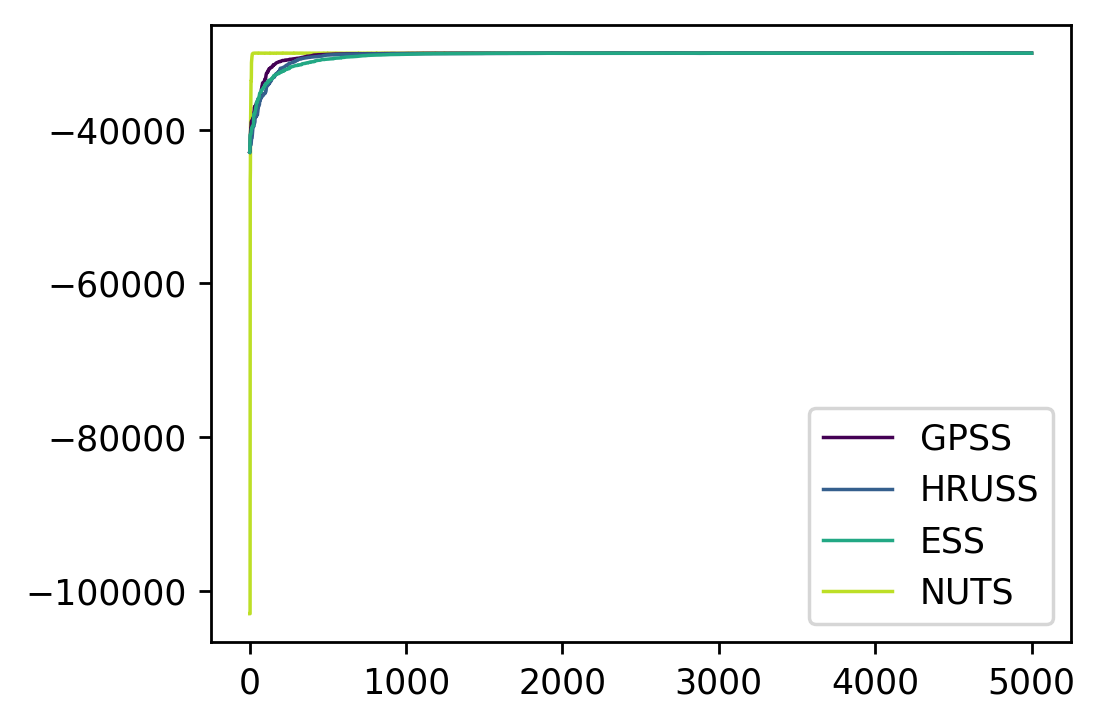

In [38]:
joint_trace_plot(log_pdf_vals, "log_pdf_vals")

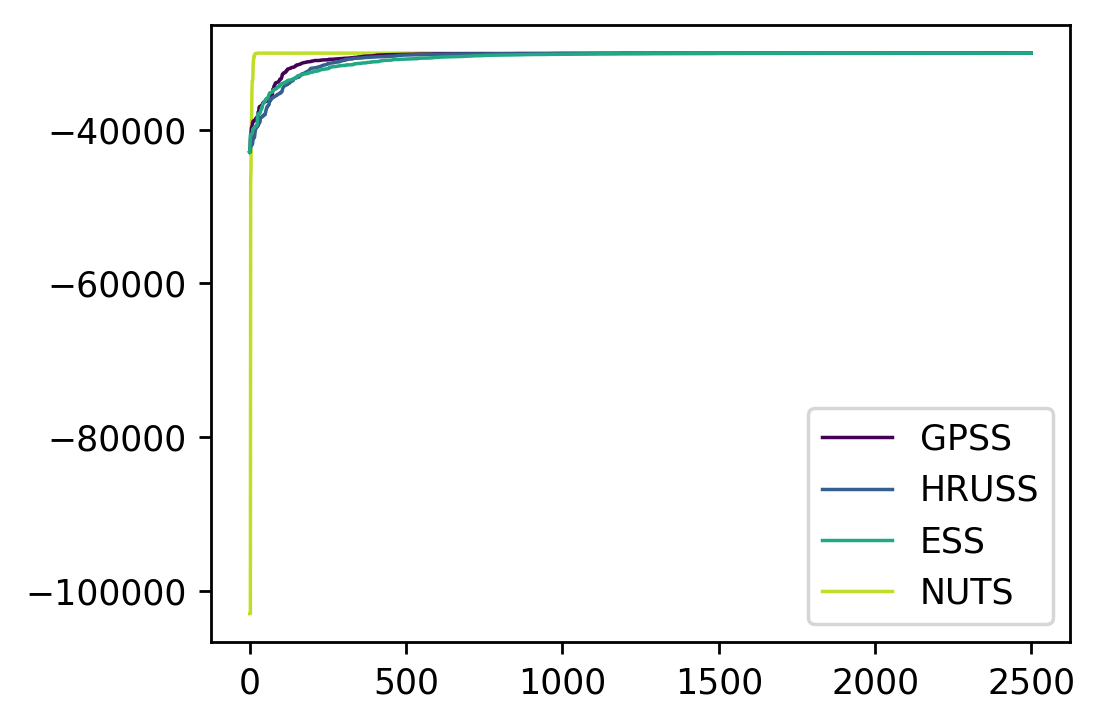

In [39]:
joint_trace_plot([lpv[:burn_in] for lpv in log_pdf_vals], "log_pdf_vals_before_burn_in")

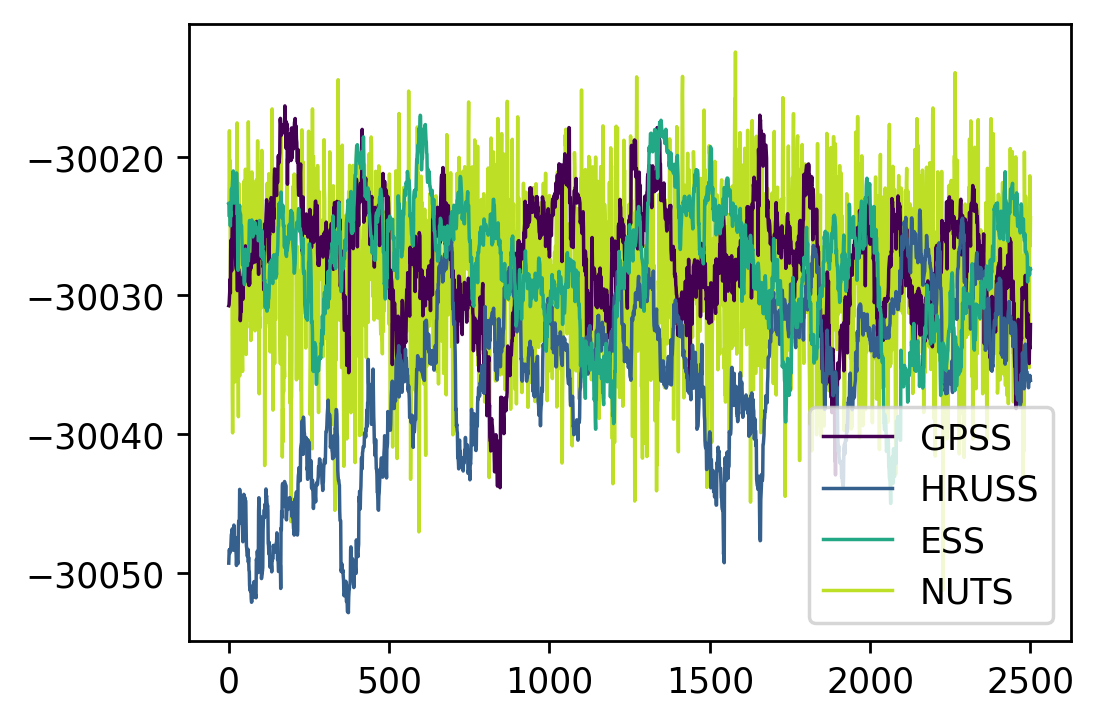

In [40]:
joint_trace_plot(mcu.remove_burn_in(log_pdf_vals, burn_in), "log_pdf_vals_after_burn_in")

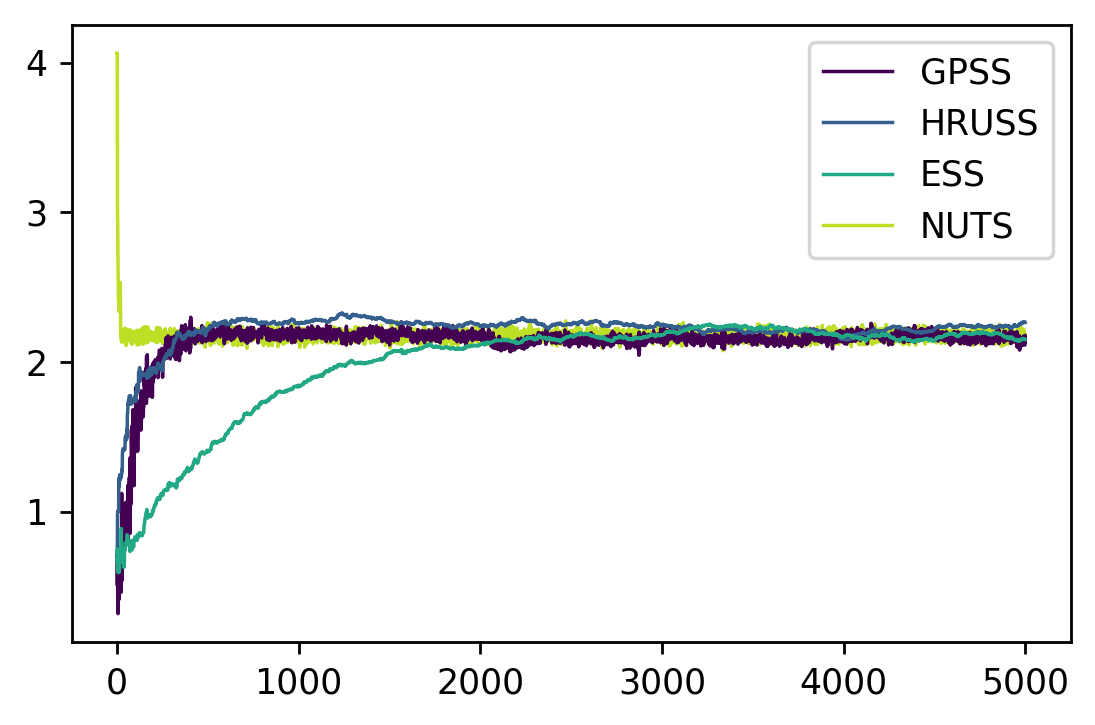

In [41]:
joint_trace_plot(radii, "radii_overlay")

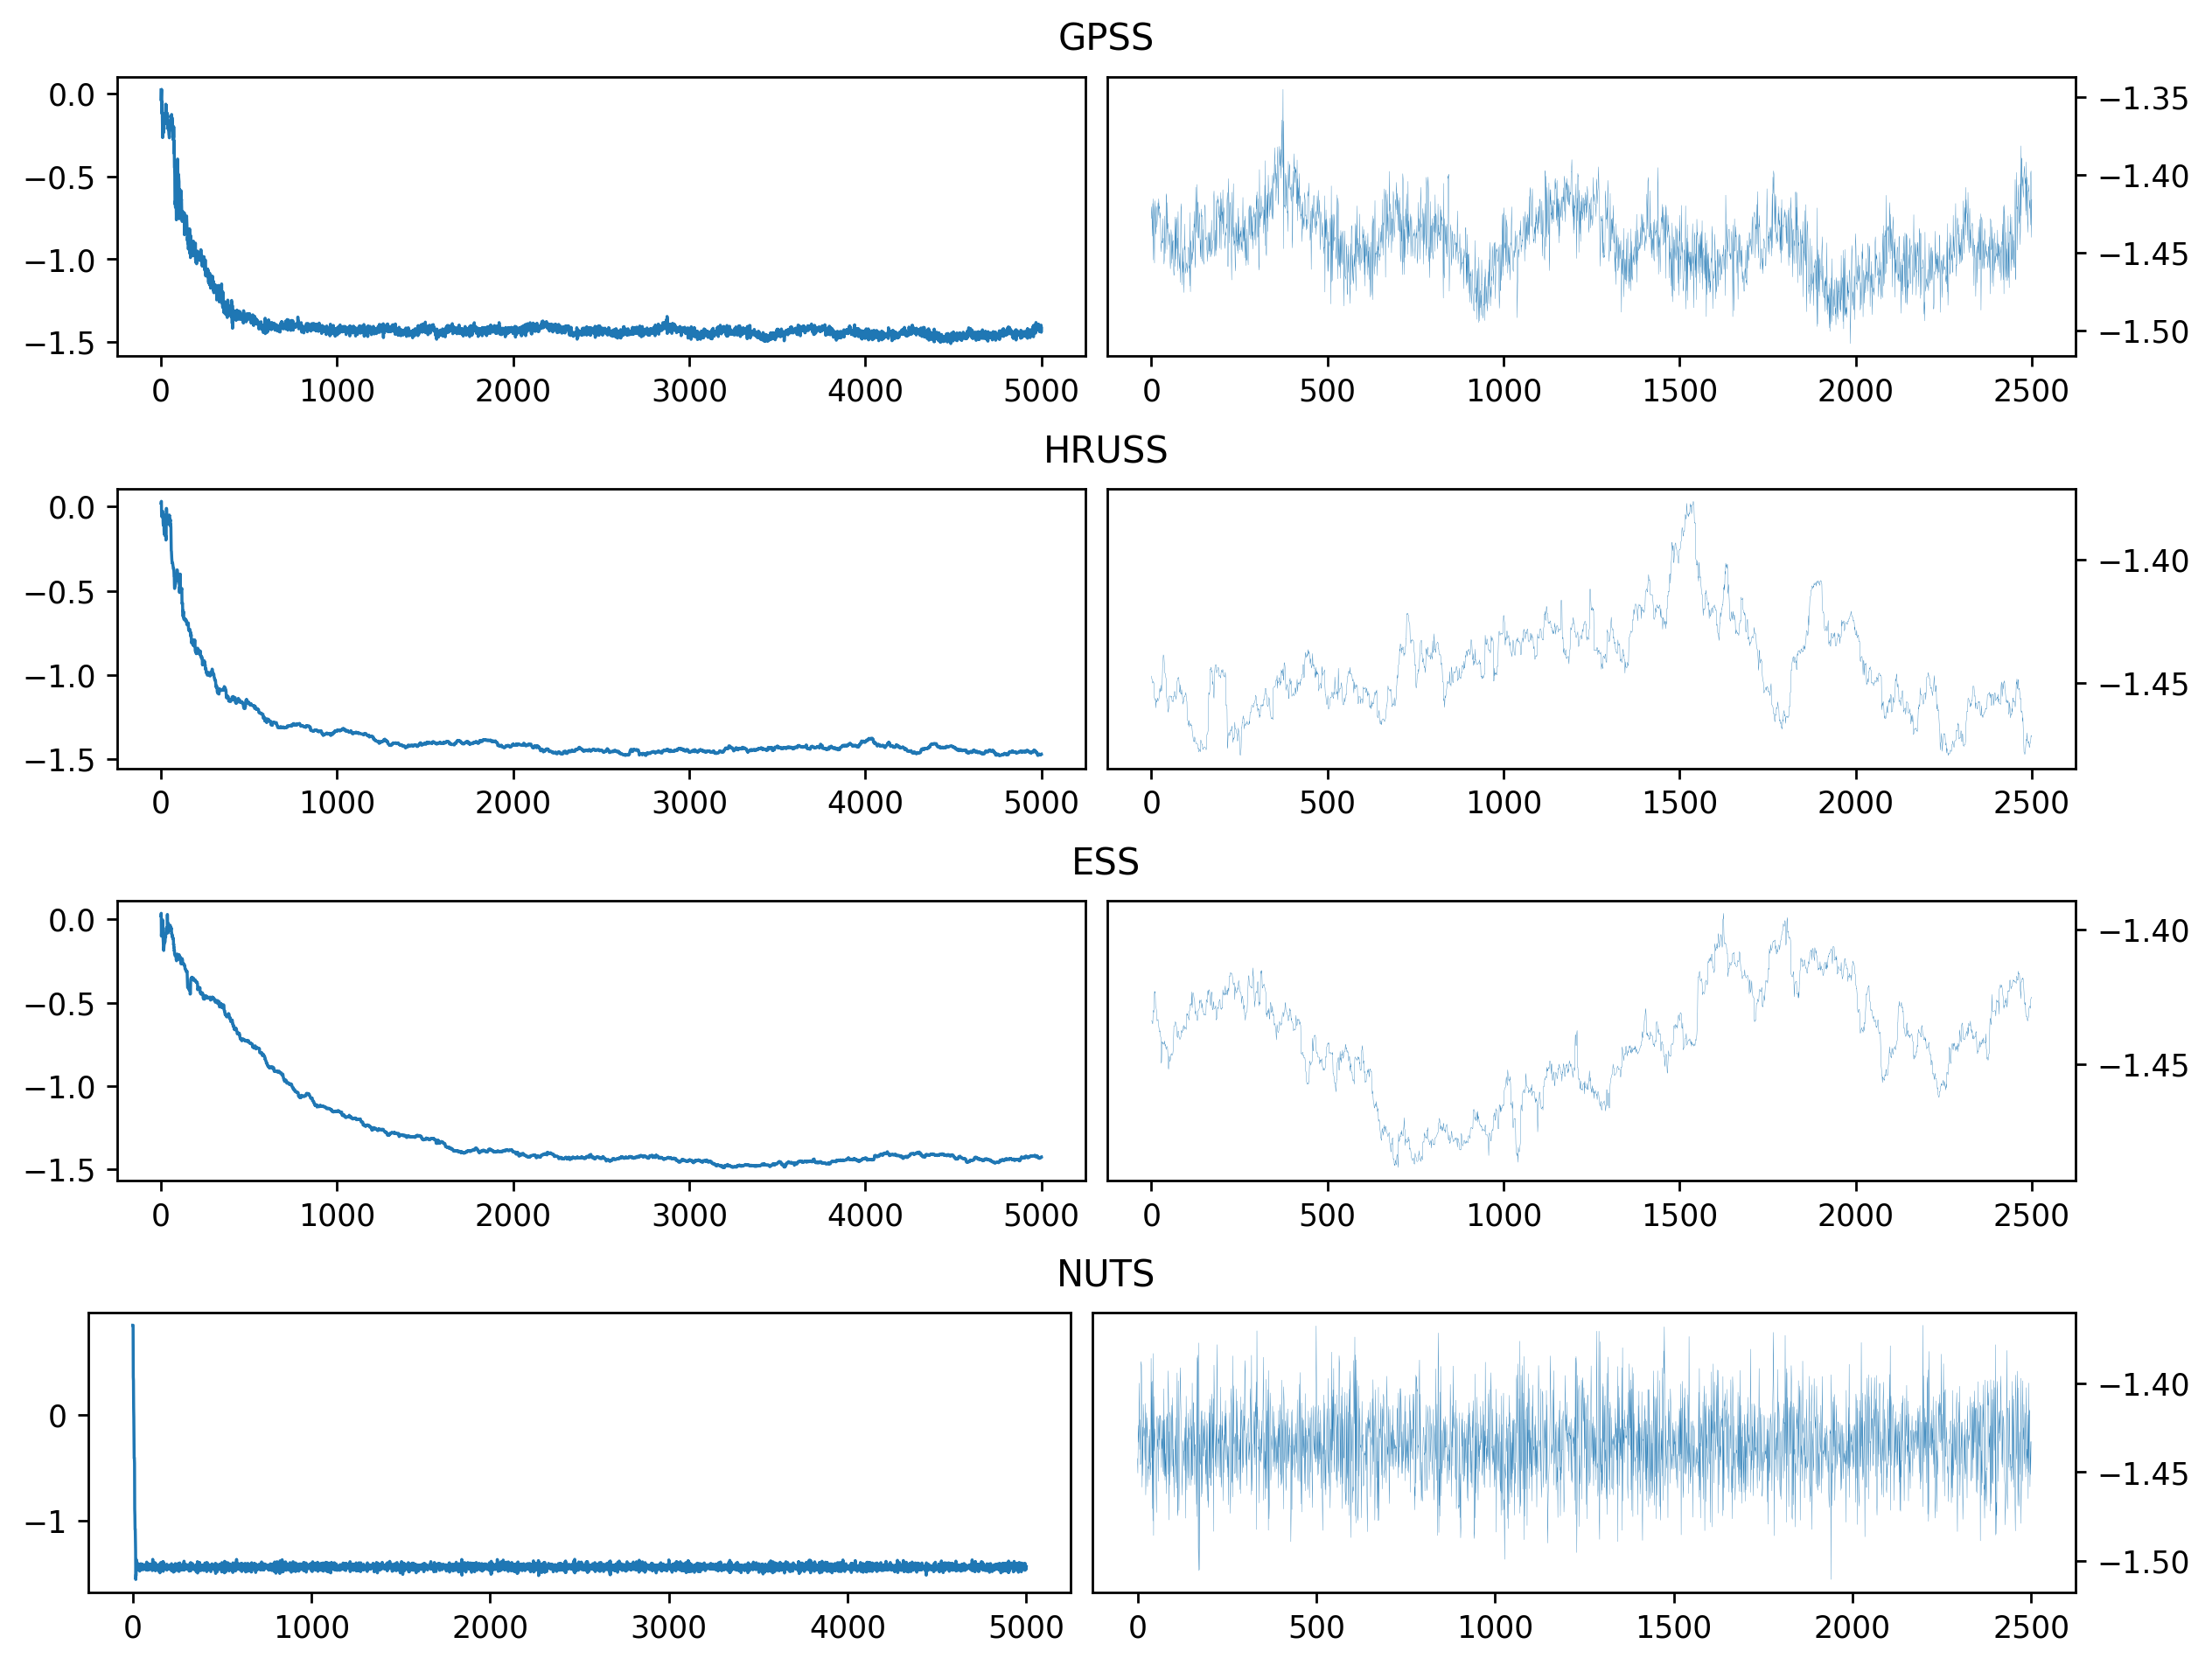

In [42]:
pfs.plot_traces_2_col(full_msamples_1, msamples_1, algnames, (10,7.5), 250, path_prefix + "traces_1.png", lw1=1, lw2=0.1)

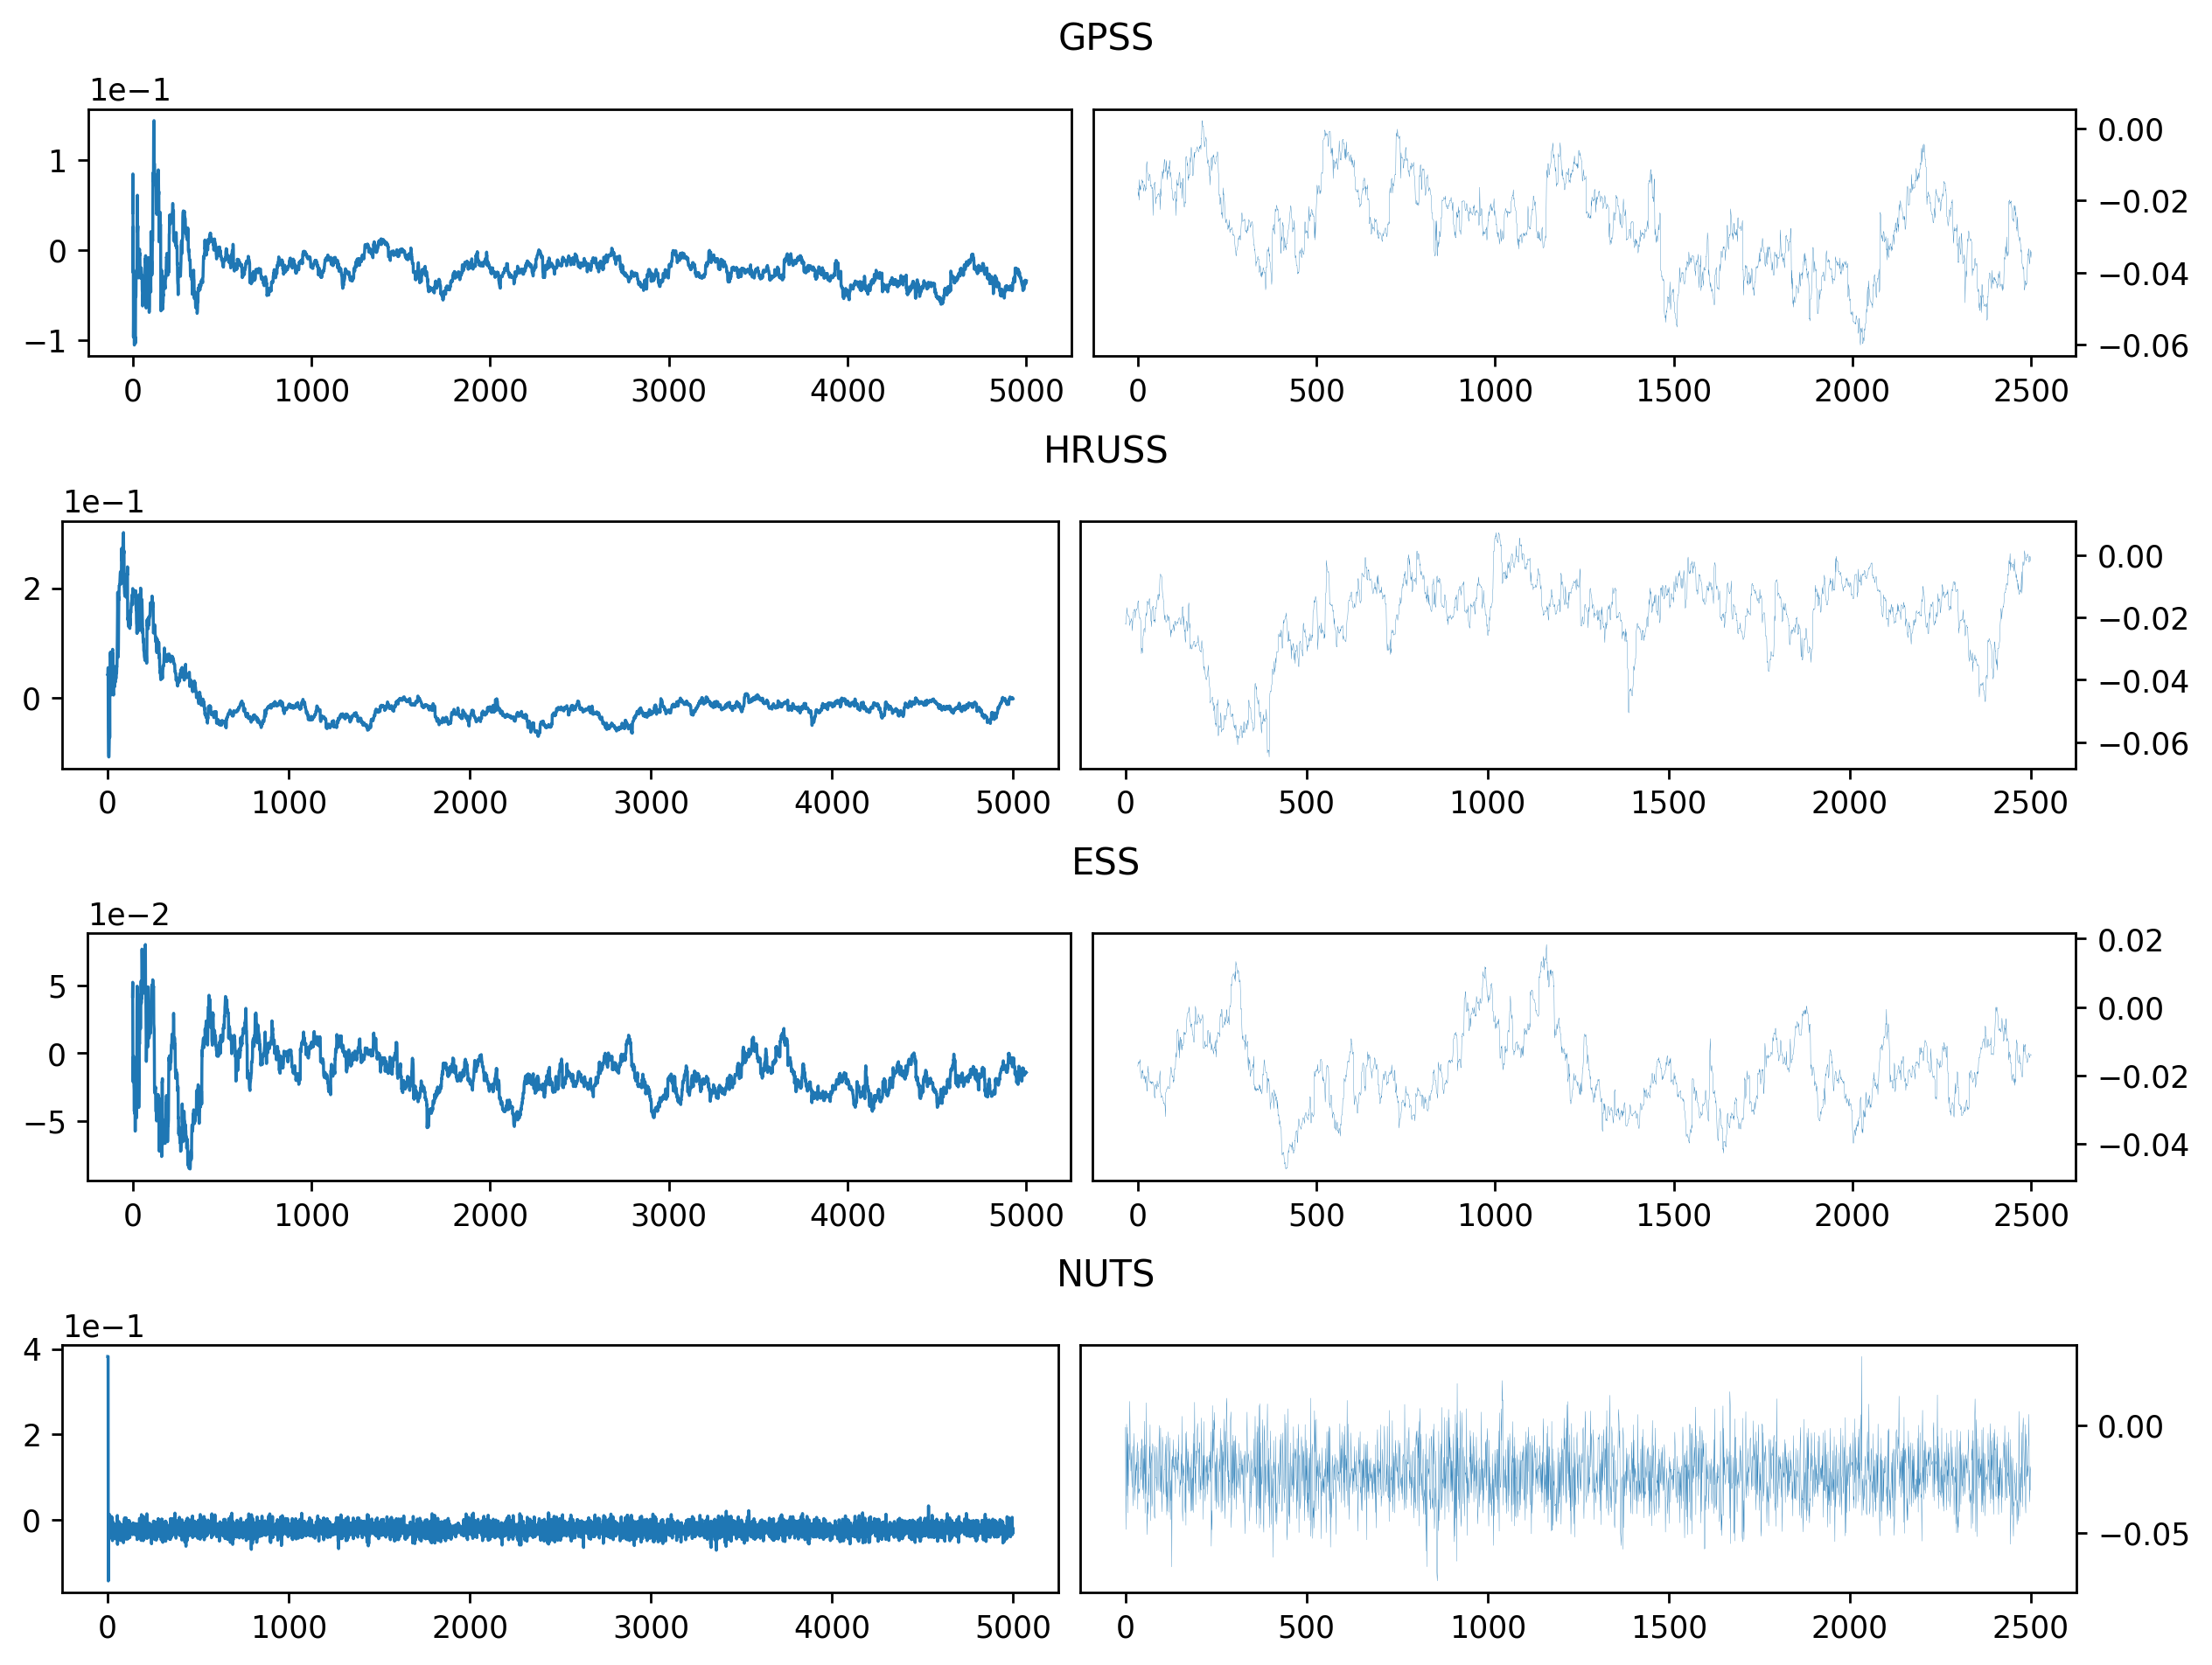

In [43]:
pfs.plot_traces_2_col(full_msamples_2, msamples_2, algnames, (10,7.5), 250, path_prefix + "traces_2.png", lw1=1, lw2=0.1)